# TAA Project 2 - BERT

In [5]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### 1. Importing Data

In [6]:
#df = pd.read_json("dataset/Sarcasm_Headlines_Dataset.json", lines=True)
df = pd.read_json("dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
df.drop('article_link', axis=1, inplace=True)

### 2. Basic Data Cleaning

In [8]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

C:\Users\Gui\AppData\Local\Temp\ipykernel_4456\167657348.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### 3. Creating the vocabulary

In [10]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
corpus[:5]

['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock']

In [11]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'new': 1637,
 'man': 1351,
 'trump': 1284,
 'one': 527,
 'area': 494,
 'woman': 483,
 'says': 482,
 'donald': 472,
 'day': 435,
 'like': 428}

### 4. Model Building

In [12]:
X = df['headline']
y = df['is_sarcastic']

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0 , stratify = y)

In [14]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [15]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [16]:
x_train = fast_encode(X_train.values, fast_tokenizer, maxlen=400)
x_test = fast_encode(X_test.values, fast_tokenizer, maxlen=400)

In [17]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [19]:
model = build_model(bert_model, max_len=400)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 400)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 400,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                             

In [20]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)

Epoch 1/3
671/671 [==============================] - 19900s 30s/step - loss: 0.5364 - accuracy: 0.7089 - val_loss: 0.4115 - val_accuracy: 0.8157
Epoch 2/3
671/671 [==============================] - 19570s 29s/step - loss: 0.3488 - accuracy: 0.8461 - val_loss: 0.3741 - val_accuracy: 0.8319
Epoch 3/3
671/671 [==============================] - 20333s 30s/step - loss: 0.2276 - accuracy: 0.9077 - val_loss: 0.4513 - val_accuracy: 0.8191


In [21]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

224/224 [==============================] - 1988s 9s/step - loss: 0.4513 - accuracy: 0.8191
Accuracy of the model on Testing Data is -  81.91474676132202 %


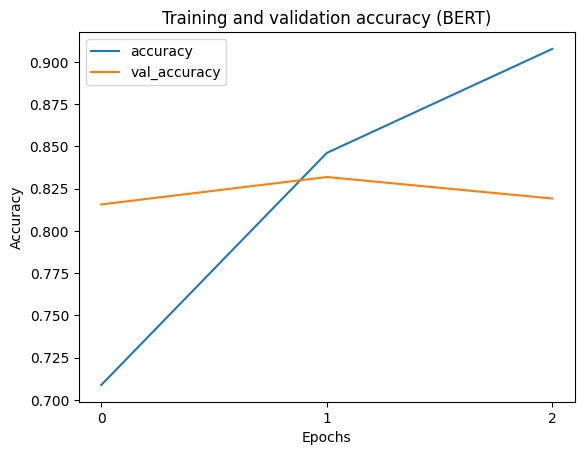

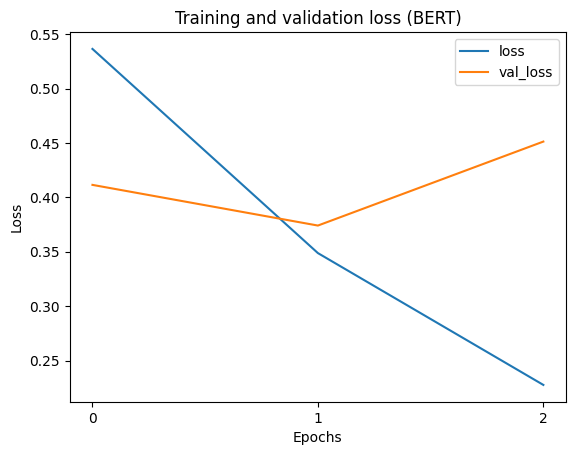

In [47]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(train_acc)
plt.plot(val_acc)
plt.locator_params(axis="x", integer=True, tight=True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and validation accuracy (BERT)')
plt.savefig('BERT_accuracy.png')
plt.show()

plt.plot(train_loss)
plt.plot(val_loss)
plt.locator_params(axis="x", integer=True, tight=True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['loss', 'val_loss'])
plt.title('Training and validation loss (BERT)')
plt.savefig('BERT_loss.png')
plt.show()

In [23]:
pred = model.predict(x_test)
pred[:5]

224/224 [==============================] - 2091s 9s/step


array([[0.99988985],
       [0.9940867 ],
       [0.37939152],
       [0.49370614],
       [0.4087561 ]], dtype=float32)

In [24]:
pred = np.round(pred).astype(int)
pred[:5]

array([[1],
       [1],
       [0],
       [0],
       [0]])

In [25]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      3746
           1       0.76      0.90      0.83      3409

    accuracy                           0.82      7155
   macro avg       0.83      0.82      0.82      7155
weighted avg       0.83      0.82      0.82      7155



In [29]:
cm = confusion_matrix(y_test,pred)
cm


array([[2783,  963],
       [ 331, 3078]], dtype=int64)

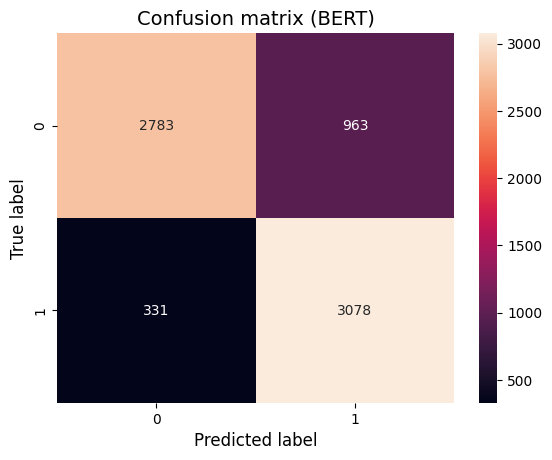

In [48]:
sns.heatmap(cm, annot = True, fmt='d')
plt.title("Confusion matrix (BERT)", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('BERT_confusion_matrix.png')